# GLayout Current Mirror Tutorial - Live Demo Session


```
OpenFASOC Team, Feb 2024
SPDX-License-Identifier: Apache-2.0
```

## Introduction
Welcome!
This notebook serves as an introduction to the GDSFactory-based layout automation tool **GLayout** and an example producing a VIA to explain grules and glayers, as a part of [OpenFASoC](https://github.com/idea-fasoc/OpenFASOC). Compared to the `GLayout_Cmirror.ipynb` example, this file contains a more detailed walk-through and explanation of the code. Netlist generation capability is also added along with a LVS / DRC check example.




## Installation On Google Collab
### 1. Clone the repository and install dependencies
**Python Dependencies**
* [`gdsfactory`](https://github.com/gdsfactory/gdsfactory): Provides the backend for GDS manipulation.
* [`sky130`](https://github.com/gdsfactory/skywater130): The Skywater 130nm PDK Python package for GDSFactory to use in this demo.
* [`gf180`](https://github.com/gdsfactory/gf180): The GF 180nm PDK Python package for GDSFactory to use in this demo.
* [`gdstk`](https://heitzmann.github.io/gdstk/): (installed as a part of gdsfactory) Used for converting GDS files into SVG images for viewing.
* [`svgutils`](https://svgutils.readthedocs.io/en/latest/): To scale the SVG image.

**System Dependencies**
* [`klayout`](https://klayout.de/): For DRC (Design Rule Checking).

#### 1.1. Install the dependencies

Installing the binary dependency `klayout` using micromamba
**You only need to run this once**
 

In [1]:
# Install python dependencies
!pip install glayout
!pip install sky130
!pip install gf180 prettyprinttree svgutils
!pip install gdsfactory==7.7.0

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.8/114.8 kB 1.1 MB/s eta 0:00:00 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.3/107.3 kB 1.5 MB/s eta 0:00:00 MB/s eta 0:00:01:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 1.2 MB/s eta 0:00:00? eta -:--:--
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 770.6 kB/s eta 0:00:001m936.0 kB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 701.8 kB/s eta 0:00:001m713.6 kB/s eta 0:00:01
  Preparing metadata (setup.py) ... done
  Using cached attrs-23.2.0-py3-none-any.whl.metadata (9.5 kB)
  Preparing metadata (setup.py) ... done
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.5/159.5 kB 1.4 MB/s eta 0:00:001.5 MB/s eta 0:00:01
  Using cached pyparsing-3

In [ ]:
# On Colab, we need to install the klayout package using a binary package manager
# Install Klayout using micromamba
import pathlib
import os
# Install KLayout (via conda)
!curl -Ls https://micro.mamba.pm/api/micromamba/linux-64/latest | tar -xvj bin/micromamba
conda_prefix_path = pathlib.Path('conda-env')
CONDA_PREFIX = str(conda_prefix_path.resolve())
%env CONDA_PREFIX={CONDA_PREFIX}

!bin/micromamba create --yes --prefix $CONDA_PREFIX
# Install from the litex-hub channel
!bin/micromamba install --yes --prefix $CONDA_PREFIX \
                        --channel litex-hub \
                        --channel main \
                        klayout


#### 1.3. Importing Libraries and Utility Functions

In [2]:
from glayout.pdk.sky130_mapped import sky130_mapped_pdk as sky130
from glayout.pdk.gf180_mapped  import gf180_mapped_pdk  as gf180
import gdstk
import svgutils.transform as sg
import IPython.display
from IPython.display import clear_output
import ipywidgets as widgets

# Redirect all outputs here
hide = widgets.Output()

def display_gds(gds_file, scale = 3):
  # Generate an SVG image
  top_level_cell = gdstk.read_gds(gds_file).top_level()[0]
  top_level_cell.write_svg('out.svg')
  # Scale the image for displaying
  fig = sg.fromfile('out.svg')
  fig.set_size((str(float(fig.width) * scale), str(float(fig.height) * scale)))
  fig.save('out.svg')

  # Display the image
  IPython.display.display(IPython.display.SVG('out.svg'))

def display_component(component, scale = 3):
  # Save to a GDS file
  with hide:
    component.write_gds("out.gds")
  display_gds('out.gds', scale)


2024-05-15 00:25:09.260 | INFO     | gdsfactory.technology.layer_views:__init__:790 - Importing LayerViews from YAML file: '/Users/yukidama/miniconda3/envs/WS2/lib/python3.11/site-packages/gf180/layers.yaml'.
2024-05-15 00:25:09.280 | INFO     | gdsfactory.pdk:activate:337 - 'gf180' PDK is now active


# Current Mirror Layout Design using GLayout API

## Overview

This document provides a detailed tutorial on using the GLayout API to design and generate a layout for a PMOS current mirror circuit. It outlines the steps to initialize the layout components, place the devices, make necessary adjustments, route the connections, and generate the final layout for visualization.

## Prerequisites

Ensure that you have the following installed:
- Python environment with access to GLayout API.
- GDSFactory package for handling generic layout components.
- A PDK (Process Design Kit) appropriate for the technology node you're working on (e.g., `gf180` in this example).

## Step-by-Step Guide

### Step 1: Setting up the Environment

**1.1 Import Required Modules**
Begin by importing the necessary classes and functions from the GLayout and GDSFactory packages:



In [6]:
from glayout.primitives.guardring import tapring
from glayout.primitives.fet import pmos
from glayout.pdk.util.comp_utils import evaluate_bbox, prec_center
from glayout.pdk.mappedpdk import MappedPDK
from glayout.routing.straight_route import straight_route
from glayout.routing.c_route import c_route
from gdsfactory import Component
from glayout.pdk.gf180_mapped import gf180_mapped_pdk

from glayout.spice import Netlist

### Step 2: Define the Current Mirror Function

**2.1 Initialize the Current Mirror Component**

Within your Python script, start by defining the `currentMirror` function that takes in a `MappedPDK` object

**2.2 Create the Transistor Instances**

Use the PDK to instantiate two PMOS transistors, a reference and a mirror, with specified modifications:
```python
    pfet_ref = pmos(with_substrate_tap=False, with_dummy=(False, True))
    pfet_mir = pmos(with_substrate_tap=False, with_dummy=(True, False))
```

2024-05-15 00:25:29.076 | INFO     | gdsfactory.pdk:activate:337 - 'gf180' PDK is now active


/var/folders/25/0q4y6gv11yq5yk2wtzhzd_ph0000gn/T/ipykernel_6645/1085505452.py:19: UserWarning: Unnamed cells, 1 in 'Unnamed_66ea96e5'
  currentMirror(gf180_mapped_pdk).write_gds("cmirror_example.gds")
2024-05-15 00:25:30.187 | INFO     | gdsfactory.component:_write_library:1851 - Wrote to 'cmirror_example.gds'


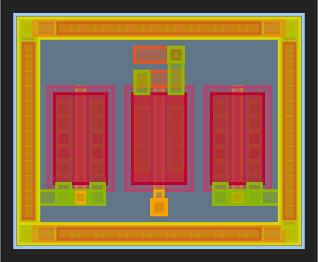

In [4]:
# Example 0: Adding a single transistor with dummy
def currentMirror(pdk: MappedPDK):
  # Note that the PDK is passed as an argument to the function
  # this provides an extra level of abstraction, allowing the user to port
  # the design to different PDKs without changing the instantiation code 

  # Define the return object
  currMirrComp = Component()
  
  # Adding one transistor with dummy, and append it to the return object 
  pfet_ref = pmos(pdk, with_substrate_tap=False, with_dummy=(True, True))
  cref_ref = currMirrComp << pfet_ref

  # Now the object contains the transistor
  return currMirrComp

# The Component() object returned by currentMirror is a GDSFactory object
# We use the .write_gds() method to generate the layout.
currentMirror(gf180_mapped_pdk).write_gds("cmirror_example.gds")

# Render the layout as a SVG image, and display it right here
display_gds("cmirror_example.gds")


**2.3 Add Transistors to the Component**

Insert the transistors into the current mirror component and position them. The transistors are then placed using explicit move commands.

```python
    cref_ref = currMirrComp << pfet_ref
    cmir_ref = currMirrComp << pfet_mir
    cref_ref.movex(evaluate_bbox(pfet_mir)[0] + max_metal_separation(pdk))
```

/var/folders/25/0q4y6gv11yq5yk2wtzhzd_ph0000gn/T/ipykernel_6645/3639840789.py:16: UserWarning: Unnamed cells, 1 in 'Unnamed_4ac2f7bb'
  currentMirror(gf180_mapped_pdk).write_gds("cmirror_example.gds")
2024-05-15 07:45:51.394 | INFO     | gdsfactory.component:_write_library:1851 - Wrote to 'cmirror_example.gds'


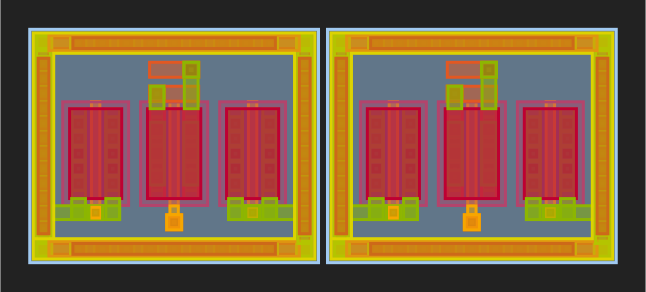

In [14]:
# Example 1: Adding a pair of transistors and place them side by side
def currentMirror(pdk: MappedPDK):
  currMirrComp = Component()
  pfet_ref = pmos(pdk, with_substrate_tap=False, with_dummy=(True, True))
  pfet_mir = pmos(pdk, with_substrate_tap=False, with_dummy=(True, True))
  cref_ref = currMirrComp << pfet_ref
  cmir_ref = currMirrComp << pfet_mir

  # Move the reference to the right
  # The distace is the size of the block + min metal separation, 
  #   the latter is obtained from the Generic PDK rules
  cref_ref.movex(evaluate_bbox(pfet_mir)[0] + pdk.util_max_metal_seperation())
  
  return currMirrComp

currentMirror(gf180_mapped_pdk).write_gds("cmirror_example.gds")
display_gds("cmirror_example.gds")

**2.4 Add and Position the Tap Ring**

Incorporate a tap ring and ensure it encloses the transistors with additional padding to satisfy design rules:

/var/folders/25/0q4y6gv11yq5yk2wtzhzd_ph0000gn/T/ipykernel_6645/3636537031.py:21: UserWarning: Unnamed cells, 1 in 'Unnamed_7a01eaa6'
  currentMirror(gf180_mapped_pdk).write_gds("cmirror_example.gds")
2024-05-15 07:45:55.487 | INFO     | gdsfactory.component:_write_library:1851 - Wrote to 'cmirror_example.gds'


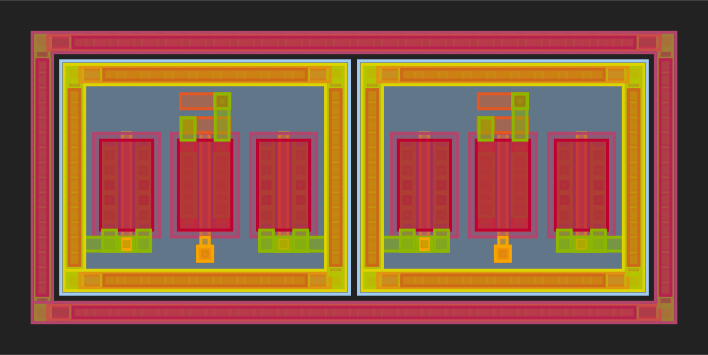

In [15]:
def currentMirror(pdk: MappedPDK):
  currMirrComp = Component()
  pfet_ref = pmos(pdk, with_substrate_tap=False, with_dummy=(True, True))
  pfet_mir = pmos(pdk, with_substrate_tap=False, with_dummy=(True, True))
  cref_ref = currMirrComp << pfet_ref
  cmir_ref = currMirrComp << pfet_mir
  cref_ref.movex(evaluate_bbox(pfet_mir)[0] + pdk.util_max_metal_seperation())
  
  # Adding a tapring around the entire cell, place it at the correct location
  # The size of the tapring is the bounding box of the two transistors
  tap_ring = tapring(pdk, enclosed_rectangle=evaluate_bbox(currMirrComp.flatten(), padding=pdk.get_grule("nwell", "active_diff")["min_enclosure"]))
  # Obtain mid-point of the two trasistors
  shift_amount = -prec_center(currMirrComp.flatten())[0] 
  # Instantiate the tapring
  tring_ref = currMirrComp << tap_ring
  # ...and move it to the mid-point
  tring_ref.movex(destination=shift_amount)

  return currMirrComp

currentMirror(gf180_mapped_pdk).write_gds("cmirror_example.gds")
display_gds("cmirror_example.gds")

**2.5 Routing**

Create routing using the tree of ports of the existing structure. The routing is currently done explictly by the user. The user need to connect them in the correct way and utilize the provided generic PDK DRC helpers to ensure the design is DRC clean. Autmated routing is currenly under development.

/var/folders/25/0q4y6gv11yq5yk2wtzhzd_ph0000gn/T/ipykernel_6645/862368397.py:27: UserWarning: Unnamed cells, 1 in 'Unnamed_a3186299'
  currentMirror(gf180_mapped_pdk).write_gds("cmirror_example.gds")
2024-05-15 07:46:58.318 | INFO     | gdsfactory.component:_write_library:1851 - Wrote to 'cmirror_example.gds'


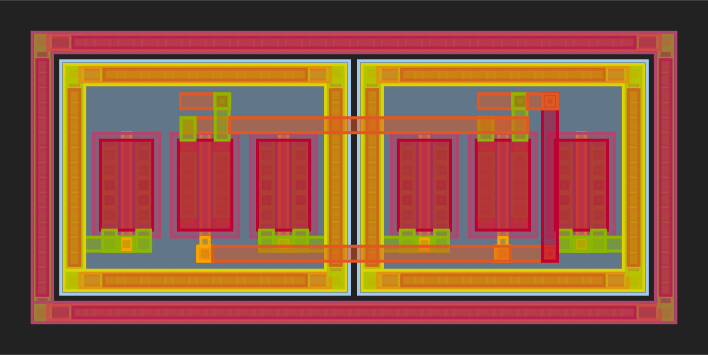

In [20]:
def currentMirror(pdk: MappedPDK):
  currMirrComp = Component()
  pfet_ref = pmos(pdk, with_substrate_tap=False, with_dummy=(True, True))
  pfet_mir = pmos(pdk, with_substrate_tap=False, with_dummy=(True, True))
  cref_ref = currMirrComp << pfet_ref
  cmir_ref = currMirrComp << pfet_mir
  pdk.util_max_metal_seperation()
  cref_ref.movex(evaluate_bbox(pfet_mir)[0] + pdk.util_max_metal_seperation())
  tap_ring = tapring(pdk, enclosed_rectangle=evaluate_bbox(currMirrComp.flatten(), padding=pdk.get_grule("nwell", "active_diff")["min_enclosure"]))
  shift_amount = -prec_center(currMirrComp.flatten())[0]
  tring_ref = currMirrComp << tap_ring
  tring_ref.movex(destination=shift_amount)

  # Add routing
  # The port syntax is hierarchical, 
  # multiplifer_0_source_E means: Multiplier number 0, source terminal, East Edge
  # 
  # Route Reference Source to Load Source
  currMirrComp << straight_route(pdk, cref_ref.ports["multiplier_0_source_E"], cmir_ref.ports["multiplier_0_source_E"])
  # Route Reference Gate to Load Gate
  currMirrComp << straight_route(pdk, cref_ref.ports["multiplier_0_gate_E"  ], cmir_ref.ports["multiplier_0_gate_E"  ])
  # Route Reference Gate to Reference Drain 
  currMirrComp << c_route(       pdk, cref_ref.ports["multiplier_0_gate_E"  ], cref_ref.ports["multiplier_0_drain_E" ])
  
  return currMirrComp

currentMirror(gf180_mapped_pdk).write_gds("cmirror_example.gds")
display_gds("cmirror_example.gds")

**2.6 Parameterize**

A proper GLayout design does not use hard-coded values. Instead, it uses parameters to allow for easy modifications. The parameters are defined at the beginning of the script and used throughout the design. In the following example, I added "number of fingers" to the mirroring transistor as a parameter. This parameter is exposed as an argument of the `currentMirror` function.


/var/folders/25/0q4y6gv11yq5yk2wtzhzd_ph0000gn/T/ipykernel_6645/3995877945.py:27: UserWarning: Unnamed cells, 1 in 'Unnamed_8dbff7a0'
  currentMirror(gf180_mapped_pdk).write_gds("cmirror_example.gds")
2024-05-15 07:49:24.114 | INFO     | gdsfactory.component:_write_library:1851 - Wrote to 'cmirror_example.gds'


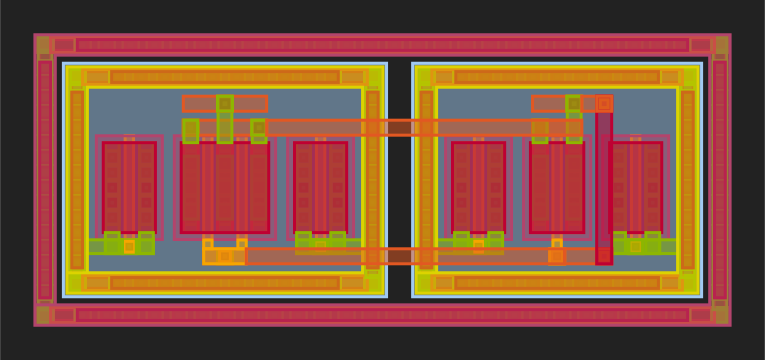

In [21]:
def currentMirror(pdk: MappedPDK, ratio: int = 2):
  currMirrComp = Component()
  pfet_ref = pmos(pdk, with_substrate_tap=False, with_dummy=(True, True))
  pfet_mir = pmos(pdk, fingers=ratio, with_substrate_tap=False, with_dummy=(True, True))
  cref_ref = currMirrComp << pfet_ref
  cmir_ref = currMirrComp << pfet_mir
  pdk.util_max_metal_seperation()
  cref_ref.movex(evaluate_bbox(pfet_mir)[0] + pdk.util_max_metal_seperation())
  tap_ring = tapring(pdk, enclosed_rectangle=evaluate_bbox(currMirrComp.flatten(), padding=pdk.get_grule("nwell", "active_diff")["min_enclosure"]))
  shift_amount = -prec_center(currMirrComp.flatten())[0]
  tring_ref = currMirrComp << tap_ring
  tring_ref.movex(destination=shift_amount)

  # Add routing
  # The port syntax is hierarchical, 
  # multiplifer_0_source_E means: Multiplier number 0, source terminal, East Edge
  # 
  # Route Reference Source to Load Source
  currMirrComp << straight_route(pdk, cref_ref.ports["multiplier_0_source_E"], cmir_ref.ports["multiplier_0_source_E"])
  # Route Reference Gate to Load Gate
  currMirrComp << straight_route(pdk, cref_ref.ports["multiplier_0_gate_E"  ], cmir_ref.ports["multiplier_0_gate_E"  ])
  # Route Reference Gate to Reference Drain 
  currMirrComp << c_route(       pdk, cref_ref.ports["multiplier_0_gate_E"  ], cref_ref.ports["multiplier_0_drain_E" ])
  
  return currMirrComp

currentMirror(gf180_mapped_pdk).write_gds("cmirror_example.gds")
display_gds("cmirror_example.gds")

/var/folders/25/0q4y6gv11yq5yk2wtzhzd_ph0000gn/T/ipykernel_6645/831035787.py:4: UserWarning: Unnamed cells, 1 in 'Unnamed_ad2e62dd'
  currentMirror(gf180_mapped_pdk, i).write_gds(f"cmirror_example_{i}.gds")
2024-05-15 07:51:16.728 | INFO     | gdsfactory.component:_write_library:1851 - Wrote to 'cmirror_example_1.gds'


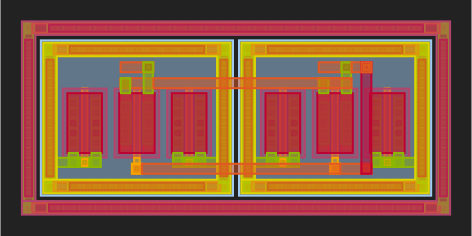

/var/folders/25/0q4y6gv11yq5yk2wtzhzd_ph0000gn/T/ipykernel_6645/831035787.py:4: UserWarning: Unnamed cells, 1 in 'Unnamed_805fd06d'
  currentMirror(gf180_mapped_pdk, i).write_gds(f"cmirror_example_{i}.gds")
2024-05-15 07:51:19.580 | INFO     | gdsfactory.component:_write_library:1851 - Wrote to 'cmirror_example_2.gds'


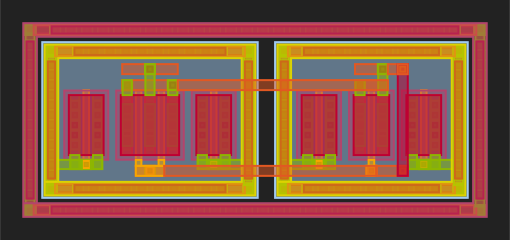

/var/folders/25/0q4y6gv11yq5yk2wtzhzd_ph0000gn/T/ipykernel_6645/831035787.py:4: UserWarning: Unnamed cells, 1 in 'Unnamed_7bc32f68'
  currentMirror(gf180_mapped_pdk, i).write_gds(f"cmirror_example_{i}.gds")
2024-05-15 07:51:22.569 | INFO     | gdsfactory.component:_write_library:1851 - Wrote to 'cmirror_example_3.gds'


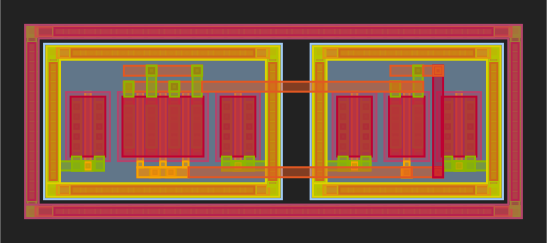

/var/folders/25/0q4y6gv11yq5yk2wtzhzd_ph0000gn/T/ipykernel_6645/831035787.py:4: UserWarning: Unnamed cells, 1 in 'Unnamed_7073504f'
  currentMirror(gf180_mapped_pdk, i).write_gds(f"cmirror_example_{i}.gds")
2024-05-15 07:51:29.888 | INFO     | gdsfactory.component:_write_library:1851 - Wrote to 'cmirror_example_4.gds'


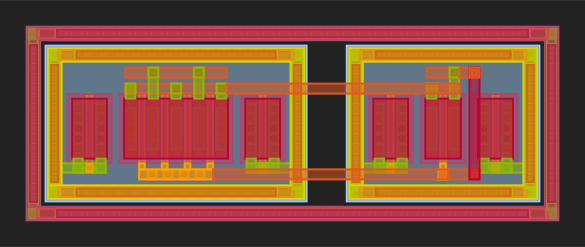

In [24]:
# It's now possible to sweep this parameter and generate different layouts

for i in range(1, 5):
  currentMirror(gf180_mapped_pdk, i).write_gds(f"cmirror_example_{i}.gds")
  display_gds(f"cmirror_example_{i}.gds", scale=2)

**2.7 Netlist Generation**

The GLayout framework also provides interfaces for creating netlist. The netlist is constructed in a similar mannar to the Layout.
By adding a netlist generator, the user can now run LVS verification and make sure the layout is electrically correct.


In [13]:
def currentMirror(pdk: MappedPDK):
  currMirrComp = Component()
  pfet_ref = pmos(pdk, with_substrate_tap=False, with_dummy=(True, True))
  pfet_mir = pmos(pdk, with_substrate_tap=False, with_dummy=(True, True))
  cref_ref = currMirrComp << pfet_ref
  cmir_ref = currMirrComp << pfet_mir
  pdk.util_max_metal_seperation()
  cref_ref.movex(evaluate_bbox(pfet_mir)[0] + pdk.util_max_metal_seperation())
  tap_ring = tapring(pdk, enclosed_rectangle=evaluate_bbox(currMirrComp.flatten(), padding=pdk.get_grule("nwell", "active_diff")["min_enclosure"]))
  shift_amount = -prec_center(currMirrComp.flatten())[0]
  tring_ref = currMirrComp << tap_ring
  tring_ref.movex(destination=shift_amount)
  currMirrComp << straight_route(pdk, cref_ref.ports["multiplier_0_source_E"], cmir_ref.ports["multiplier_0_source_E"])
  currMirrComp << straight_route(pdk, cref_ref.ports["multiplier_0_gate_E"  ], cmir_ref.ports["multiplier_0_gate_E"  ])
  currMirrComp << c_route(       pdk, cref_ref.ports["multiplier_0_gate_E"  ], cref_ref.ports["multiplier_0_drain_E" ])


  # Netlist Generator Code
  currMirrNL = Netlist(
    circuit_name="current_mirror",
    nodes=["VDD", "VSS", "IIN", "IOUT"]
  )
  cref_nl = currMirrNL.connect_netlist(
    pfet_ref.info["netlist"],
    [('D', 'IIN'), ('G', 'IIN'), ('S', 'VSS'), ('B', 'VSS')]
  )
  cmir_nl = currMirrNL.connect_netlist(
    pfet_mir.info["netlist"],
    [('D', 'IOUT'), ('G', 'IIN'), ('S', 'VSS'), ('B', 'VSS')]
  )

  currMirrComp.info["netlist"] = currMirrNL.generate_netlist()
  return currMirrComp

print(currentMirror(gf180_mapped_pdk).info["netlist"])

.subckt PMOS D G S B l=1 w=1 m=1 dm=1
XMAIN   D G S B pfet_03v3 l={l} w={w} m={m}
XDUMMY1 B B B B pfet_03v3 l={l} w={w} m={dm}
.ends PMOS

.subckt current_mirror VDD VSS IIN IOUT
X0 IIN IIN VSS VSS PMOS l=None w=3 m=1 dm=1
X1 IOUT IIN VSS VSS PMOS l=None w=3 m=1 dm=1
.ends current_mirror


## Conclusion

Following these steps results in a PMOS current mirror layout being composed and visualized. The tap ring encloses the transistors and the routing utilities are used to create the required connections respecting the design rules specified by the PDK.

Each function call and module used here directly corresponds to a specific structure or operation within the context of the PDK and the layout process. This example provides a foundation upon which more complex circuits can be designed using the powerful features of the GLayout API.